# **Introdution**

In [45]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import PyTorch and related modules
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# Import torchvision transformations
from torchvision import transforms as T

# Import a popular image model library
import timm

# **First Image**

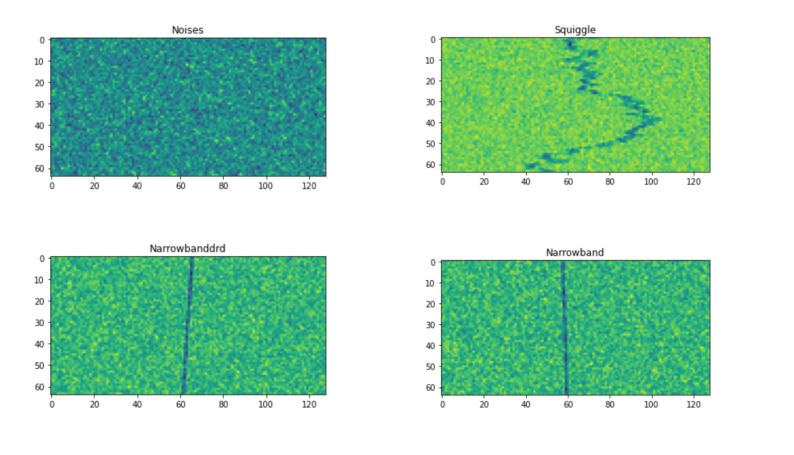

In [46]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# The path to the image that has been uploaded
image_path = "C:/Users/Asus/Desktop/Coursera/Classify Radio Signals with PyTorch/Project/Project/Untitled-design.png"

# Load and display the image
img = mpimg.imread(image_path)

# Set the figure size to HD resolution

# Set the size to 10 inches by 10 inches
plt.figure(figsize=(10, 10)) 

plt.imshow(img)

# Turn off axes
plt.axis('off')
plt.show()

# **Configurations**

In [47]:
# Paths to the training and validation CSV files
TRAIN_CSV = 'C:/Users/Asus/Desktop/Coursera/Classify Radio Signals with PyTorch/Project/Project/train.csv'
VALID_CSV = 'C:/Users/Asus/Desktop/Coursera/Classify Radio Signals with PyTorch/Project/Project/valid.csv'

# Batch size for training and validation data
BATCH_SIZE = 128

# Device to use for training ('cpu' for CPU, 'cuda' for GPU if available)
DEVICE = 'cpu'

# Name of the pre-trained model architecture to use
MODEL_NAME = 'efficient_b0'

# Learning rate for the optimizer
LR = 0.001

# Number of training epochs
EPOCHS = 15

In [48]:
df_train = pd.read_csv(TRAIN_CSV)
df_valid = pd.read_csv(VALID_CSV)

df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,8183,8184,8185,8186,8187,8188,8189,8190,8191,labels
0,0.631373,0.623529,0.713726,0.705882,0.658824,0.666667,0.654902,0.635294,0.647059,0.705882,...,0.611765,0.650980,0.658824,0.600000,0.603922,0.654902,0.694118,0.658824,0.666667,Squiggle
1,0.725490,0.752941,0.749020,0.701961,0.690196,0.721569,0.709804,0.745098,0.654902,0.721569,...,0.698039,0.721569,0.686275,0.713726,0.682353,0.690196,0.698039,0.701961,0.725490,Squiggle
2,0.717647,0.701961,0.713726,0.733333,0.705882,0.717647,0.725490,0.682353,0.717647,0.674510,...,0.694118,0.705882,0.682353,0.639216,0.713726,0.670588,0.678431,0.737255,0.674510,Squiggle
3,0.705882,0.674510,0.654902,0.678431,0.666667,0.662745,0.678431,0.662745,0.686275,0.686275,...,0.662745,0.631373,0.643137,0.705882,0.662745,0.705882,0.666667,0.654902,0.631373,Squiggle
4,0.647059,0.729412,0.701961,0.674510,0.611765,0.698039,0.713726,0.662745,0.701961,0.674510,...,0.670588,0.705882,0.674510,0.721569,0.694118,0.674510,0.705882,0.749020,0.729412,Squiggle


In [49]:
print(f"No. of examples present in df_train : {len(df_train)}")
print(f"No. of examples present in df_valid : {len(df_valid)}")
print(f"Labels are : {df_train['labels'].unique()}")

No. of examples present in df_train : 3200
No. of examples present in df_valid : 800
Labels are : ['Squiggle' 'Narrowbanddrd' 'Noises' 'Narrowband']


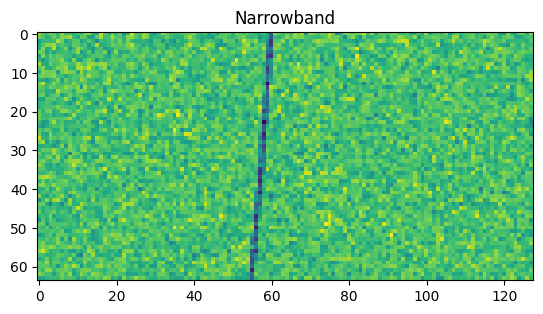

In [50]:
idx = 3100 # Index No.

row = df_train.iloc[idx]

# row = df_valid.iloc[idx]

# Converting a specific row data from 'train.csv' dataset into image
image_pixels = np.array(row[0:8192], dtype = np.float64)
label = row.labels

image = np.resize(image_pixels, (64, 128)) # 64*128 = 8192

plt.imshow(image)
plt.title(label); # Here without ';' shows 'Text(0.5, 1.0, '[label]')'

# **Declare Spec Augmentations**

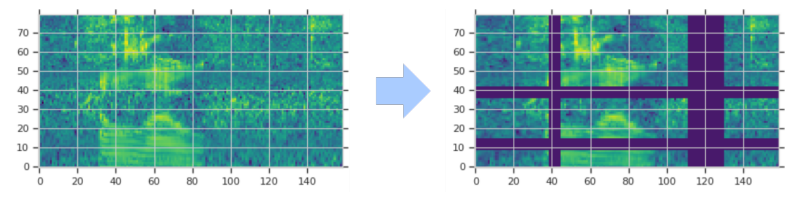

In [51]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# The path to the image that has been uploaded
image_path = "C:/Users/Asus/Desktop/Coursera/Classify Radio Signals with PyTorch/Project/Project/image6.png"


# Load and display the image
img = mpimg.imread(image_path)

# Set the figure size to HD resolution

# Set the size to 10 inches by 10 inches
plt.figure(figsize=(10, 10)) 

plt.imshow(img)

# Turn off axes
plt.axis('off')
plt.show()

In [52]:
from spec_augment import TimeMask, FreqMask

In [53]:
# Define your train transform function
def get_train_transform():
    return T.Compose([
        TimeMask(T=15, num_masks=4),  # Use the imported TimeMask class
        FreqMask(F=15, num_masks=3)   # Use the imported FreqMask class
    ])

# **Create Custom Dataset**

In [54]:
import numpy as np
import torch
from torch.utils.data import Dataset

class SpecDataset(Dataset):
    def __init__(self, df, augmentations=None):
        self.df = df
        self.augmentations = augmentations
        
        label_mapper = {
            'Squiggle': 0,
            'Narrowband': 1,
            'Narrowbanddrd': 2,
            'Noises': 3
        }
        
        self.df['labels'] = self.df['labels'].map(label_mapper)
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_pixels = np.array(row[0:8192], dtype=np.float64)
        
        image = np.resize(image_pixels, (64, 128, 1))  # (h, w, c)
        label = np.array(row['labels'], dtype=np.int64)
        
        image = torch.Tensor(image).permute(2, 0, 1)  # (c, h, w)
        
        if self.augmentations is not None:
            image = self.augmentations(image)
            
        return image.float(), label


In [55]:
trainset = SpecDataset(df_train, get_train_transform())
validset = SpecDataset(df_valid)

0


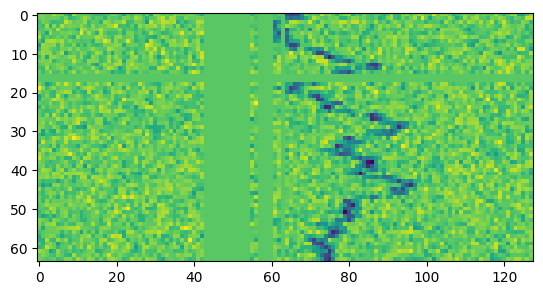

In [56]:
image, label = trainset[591]

plt.imshow(image.permute(0, 1 , 2).squeeze())
print(label)

# **Load Dataset into Batches**

In [57]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [58]:
print(f"Total no. of batches in trainloader : {len(trainloader)}")
print(f"Total no. of batches in validloader : {len(validloader)}")

Total no. of batches in trainloader : 25
Total no. of batches in validloader : 7


In [59]:
for images, labels in trainloader:
    break;
print(f"One image batch shape : {images.shape}")
print(f"One label batch shape : {labels.shape}")

One image batch shape : torch.Size([128, 1, 64, 128])
One label batch shape : torch.Size([128])


# **Load Model**

In [60]:
import timm

class SpecModel(nn.Module):
    def __init__(self):
        super(SpecModel, self).__init__()
        MODEL_NAME = 'tf_efficientnet_b0'
        self.net = timm.create_model(MODEL_NAME, num_classes=4, pretrained=True, in_chans=1)

    def forward(self, images, labels = None):
        
        logits = self.net(images)
        
        if labels is not None:
            loss = nn.CrossEntropyLoss()
            return logits, loss(logits, labels)
        return logits

In [61]:
model = SpecModel()
model;

# **Create Train and Eval Frunction**

In [62]:
from tqdm.notebook import tqdm
from utils import multiclass_accuracy

In [63]:
def train_fn(model, dataloader, optimizer, current_epoch):
    model.train()
    total_loss = 0.0
    total_acc = 0.0
    progress_bar = tqdm(dataloader, desc="EPOCH [TRAIN] " + str(current_epoch + 1) + '/' + str(EPOCHS))

    for t, data in enumerate(progress_bar):
        images, labels = data
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        logits, loss = model(images, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_acc += multiclass_accuracy(logits, labels)

        temp = {'loss' : '%6.2f' %float(total_loss/(t+1)), 'acc' : '%6.4f' %float(total_acc/(t+1))}

        progress_bar.set_postfix(temp)

    return total_loss/len(dataloader), total_acc/len(dataloader)

# Generated by Codeium

# def train_fn(model, dataloader, optimizer, current_epoch):
#     model.train()
#     train_loss = 0.0
#     train_acc = 0.0

#     for images, labels in dataloader:
#         images = images.to(DEVICE)
#         labels = labels.to(DEVICE)

#         # Check the number of channels in the input images
#         if images.size(1) != 3:
#             # If the number of channels is not 3, repeat the single channel to create 3 channels
#             images = images.repeat(1, 3, 1, 1)

#         optimizer.zero_grad()
#         logits, loss = model(images, labels)
#         loss.backward()
#         optimizer.step()

#         train_loss += loss.item()
#         train_acc += (logits.argmax(1) == labels).sum().item()

#     return train_loss / len(dataloader), train_acc / len(dataloader.dataset)


In [64]:
def valid_fn(model, dataloader, current_epoch):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    progress_bar = tqdm(dataloader, desc="EPOCH [VALID] " + str(current_epoch + 1) + '/' + str(EPOCHS))

    with torch.no_grad():
        for t, data in enumerate(progress_bar):
            images, labels = data
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            logits, loss = model(images, labels)

            total_loss += loss.item()
            total_acc += multiclass_accuracy(logits, labels)

            temp = {'loss' : '%6f' %float(total_loss/(t+1)), 'acc' : '%6f' %float(total_acc/(t+1))}

            progress_bar.set_postfix(temp)

        return total_loss/len(dataloader), total_acc/len(dataloader)

# Generated by Codeium

# def valid_fn(model, dataloader, current_epoch):
#     model.eval()
#     total_loss = 0.0
#     total_acc = 0.0

#     with torch.no_grad():
#         for images, labels in dataloader:
#             images = images.to(DEVICE)
#             labels = labels.to(DEVICE)

#             # Check the number of channels in the input images
#             if images.size(1) != 3:
#                 # If the number of channels is not 3, repeat the single channel to create 3 channels
#                 images = images.repeat(1, 3, 1, 1)

#             logits, loss = model(images, labels)

#             total_loss += loss.item()
#             total_acc += (logits.argmax(1) == labels).sum().item()

#     return total_loss / len(dataloader), total_acc / len(dataloader.dataset)


# **Training Loop**

In [65]:
def fit(model, trainloader, validloader, optimizer):

    best_valid_loss = np.inf

    for i in range(EPOCHS):
        train_loss, train_acc = train_fn(model, trainloader, optimizer, i)
        valid_loss, valid_acc = valid_fn(model, validloader, i)
        
        if valid_loss < best_valid_loss:
            torch.save(model.state_dict(), MODEL_NAME + '-best-weight.pt')
            print('SAVED-BEST-WEIGHTS')
            best_valid_loss = valid_loss

In [66]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
fit(model, trainloader, validloader, optimizer)

EPOCH [TRAIN] 1/15:   0%|          | 0/25 [00:00<?, ?it/s]

EPOCH [VALID] 1/15:   0%|          | 0/7 [00:00<?, ?it/s]

SAVED-BEST-WEIGHTS


EPOCH [TRAIN] 2/15:   0%|          | 0/25 [00:00<?, ?it/s]

EPOCH [VALID] 2/15:   0%|          | 0/7 [00:00<?, ?it/s]

SAVED-BEST-WEIGHTS


EPOCH [TRAIN] 3/15:   0%|          | 0/25 [00:00<?, ?it/s]

EPOCH [VALID] 3/15:   0%|          | 0/7 [00:00<?, ?it/s]

SAVED-BEST-WEIGHTS


EPOCH [TRAIN] 4/15:   0%|          | 0/25 [00:00<?, ?it/s]

EPOCH [VALID] 4/15:   0%|          | 0/7 [00:00<?, ?it/s]

EPOCH [TRAIN] 5/15:   0%|          | 0/25 [00:00<?, ?it/s]

EPOCH [VALID] 5/15:   0%|          | 0/7 [00:00<?, ?it/s]

SAVED-BEST-WEIGHTS


EPOCH [TRAIN] 6/15:   0%|          | 0/25 [00:00<?, ?it/s]

EPOCH [VALID] 6/15:   0%|          | 0/7 [00:00<?, ?it/s]

SAVED-BEST-WEIGHTS


EPOCH [TRAIN] 7/15:   0%|          | 0/25 [00:00<?, ?it/s]

EPOCH [VALID] 7/15:   0%|          | 0/7 [00:00<?, ?it/s]

EPOCH [TRAIN] 8/15:   0%|          | 0/25 [00:00<?, ?it/s]

EPOCH [VALID] 8/15:   0%|          | 0/7 [00:00<?, ?it/s]

EPOCH [TRAIN] 9/15:   0%|          | 0/25 [00:00<?, ?it/s]

EPOCH [VALID] 9/15:   0%|          | 0/7 [00:00<?, ?it/s]

EPOCH [TRAIN] 10/15:   0%|          | 0/25 [00:00<?, ?it/s]

EPOCH [VALID] 10/15:   0%|          | 0/7 [00:00<?, ?it/s]

EPOCH [TRAIN] 11/15:   0%|          | 0/25 [00:00<?, ?it/s]

EPOCH [VALID] 11/15:   0%|          | 0/7 [00:00<?, ?it/s]

EPOCH [TRAIN] 12/15:   0%|          | 0/25 [00:00<?, ?it/s]

EPOCH [VALID] 12/15:   0%|          | 0/7 [00:00<?, ?it/s]

EPOCH [TRAIN] 13/15:   0%|          | 0/25 [00:00<?, ?it/s]

EPOCH [VALID] 13/15:   0%|          | 0/7 [00:00<?, ?it/s]

EPOCH [TRAIN] 14/15:   0%|          | 0/25 [00:00<?, ?it/s]

EPOCH [VALID] 14/15:   0%|          | 0/7 [00:00<?, ?it/s]

EPOCH [TRAIN] 15/15:   0%|          | 0/25 [00:00<?, ?it/s]

EPOCH [VALID] 15/15:   0%|          | 0/7 [00:00<?, ?it/s]